*790.28544*

## Import

In [ ]:
!pip install koreanize_matplotlib

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/ML_9')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
international_trade = pd.read_csv('international_trade.csv')

### Description

#### train.csv
    2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
    - item: 품목 코드
        - TG : 감귤
        - BC : 브로콜리
        - RD : 무
        - CR : 당근
        - CB : 양배추
    - corporation : 유통 법인 코드
        - 법인 A부터 F 존재
    - location : 지역 코드
        - J : 제주도 제주시
        - S : 제주도 서귀포시
    - supply(kg) : 유통된 물량, kg 단위
    - price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위

#### international_trade.csv
    - 관련 품목 수출입 정보
    - 중량 단위 kg
    - 금액 단위 천 달러

#### test.csv
    2023년 03월 04일부터 2023년 03월 31일까지의 데이터

#### sample_submission.csv
    - 제출을 위한 양식
    - 2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측
    - ID는 품목, 유통 법인, 지역 코드로 구성된 식별자
    - 해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
 7   year         59397 non-null  int64  
 8   month        59397 non-null  int64  
 9   day          59397 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 4.5+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1092 non-null   object
 1   timestamp    1092 non-null   object
 2   item         1092 non-null   object
 3   corporation  1092 non-null   object
 4   location     1092 non-null   object
 5   year         1092 non-null   int64 
 6   month        1092 non-null   int64 
 7   day          1092 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 68.4+ KB


In [ ]:
international_trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 69.8+ KB


In [ ]:
display(train_df.describe().T)
display(test_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
supply(kg),59397.0,11894.525187,52263.999831,0.0,0.0,0.0,3800.0,1222800.0
price(원/kg),59397.0,1131.680674,2029.941445,0.0,0.0,0.0,1519.0,20909.0
year,59397.0,2020.601445,1.201092,2019.0,2020.0,2021.0,2022.0,2023.0
month,59397.0,6.320420,3.519942,1.0,3.0,6.0,9.0,12.0
day,59397.0,15.685489,8.804446,1.0,8.0,16.0,23.0,31.0


,count,mean,std,min,25%,50%,75%,max
year,1092.0,2023.0,0.000000,2023.0,2023.00,2023.0,2023.00,2023.0
month,1092.0,3.0,0.000000,3.0,3.00,3.0,3.00,3.0
day,1092.0,17.5,8.081448,4.0,10.75,17.5,24.25,31.0


In [ ]:
display(train_df.describe(include='object').T)
display(test_df.describe(include='object').T)

,count,unique,top,freq
ID,59397,59397,RD_F_J_20230303,1
timestamp,59397,1523,2023-03-03,39
item,59397,5,TG,15230
corporation,59397,6,A,13707
location,59397,2,J,35029


,count,unique,top,freq
ID,1092,1092,RD_F_J_20230331,1
timestamp,1092,28,2023-03-04,39
item,1092,5,TG,280
corporation,1092,6,A,252
location,1092,2,J,644


In [ ]:
display(international_trade.describe().T)
display(international_trade.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
수출 중량,1274.0,2.005844e+05,9.669554e+05,0.0,0.0,125.5,15565.25,20949417.0
수출 금액,1274.0,3.604254e+02,1.689359e+03,0.0,0.0,1.0,31.00,16278.0
수입 중량,1274.0,1.255735e+06,3.680257e+06,0.0,0.0,29269.5,1022695.50,49759137.0
수입 금액,1274.0,1.548220e+03,5.844806e+03,0.0,0.0,89.5,1253.00,84118.0
무역수지,1274.0,-1.187790e+03,6.171655e+03,-84117.0,-1240.5,-61.5,9.00,16278.0


,count,unique,top,freq
기간,1274,50,2022-08,29
품목명,1274,34,방울다다기 양배추,50


In [ ]:
train_df['timestamp'].unique()

array(['2019-01-01', '2019-01-02', '2019-01-03', ..., '2023-03-01',
       '2023-03-02', '2023-03-03'], dtype=object)

In [ ]:
international_trade['기간'].unique()

array(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02'], dtype=object)

## Visualization

In [ ]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

In [ ]:
international_trade_no_datetime = international_trade.drop(columns=['기간'])

international_trade_no_datetime['기간'] = pd.to_datetime(international_trade['기간'])
international_trade_no_datetime['Year'] = international_trade_no_datetime['기간'].dt.year
international_trade_no_datetime['Month'] = international_trade_no_datetime['기간'].dt.month
international_trade_no_datetime['YearMonth'] = international_trade_no_datetime['Year'] * 100 + international_trade_no_datetime['Month']
international_trade_no_datetime = international_trade_no_datetime.drop(columns=['기간'])

monthly_data = international_trade_no_datetime.groupby('YearMonth').sum().reset_index()
monthly_data['YearMonth'] = monthly_data['YearMonth'].astype(str)

In [ ]:
train_df_no_datetime = train_df.drop(columns=['timestamp'])

train_df_no_datetime['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df_no_datetime['Year'] = train_df_no_datetime['timestamp'].dt.year
train_df_no_datetime['Month'] = train_df_no_datetime['timestamp'].dt.month
train_df_no_datetime['YearMonth'] = train_df_no_datetime['Year'] * 100 + train_df_no_datetime['Month']
train_df_no_datetime = train_df_no_datetime.drop(columns=['timestamp'])

monthly_train_df = train_df_no_datetime.groupby('YearMonth').sum().reset_index()
monthly_train_df['YearMonth'] = monthly_train_df['YearMonth'].astype(str)

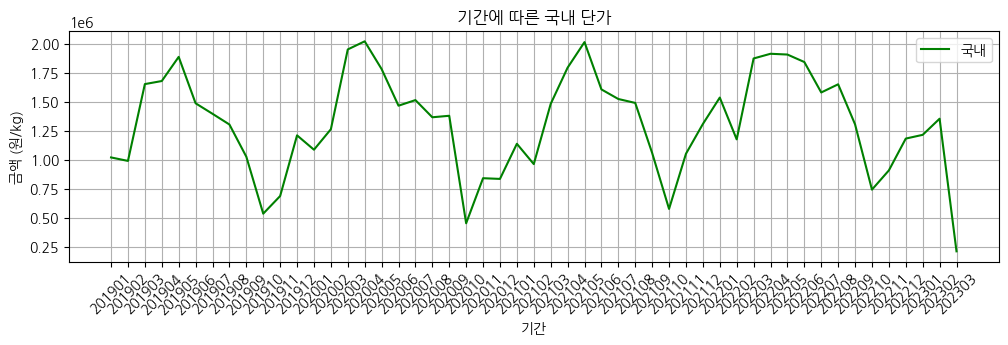

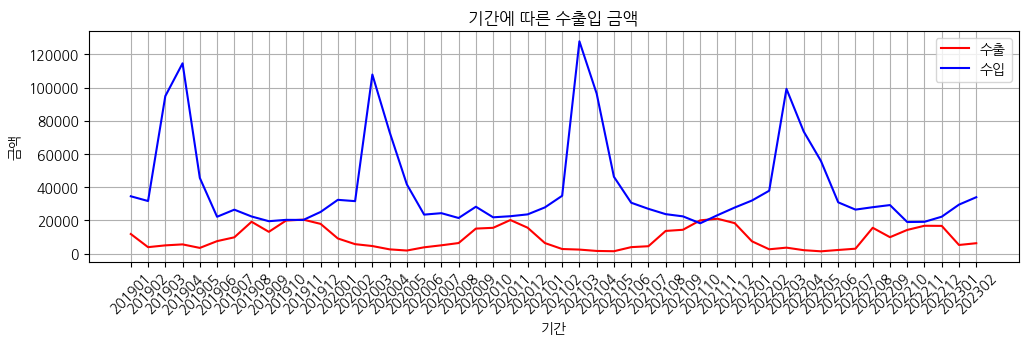

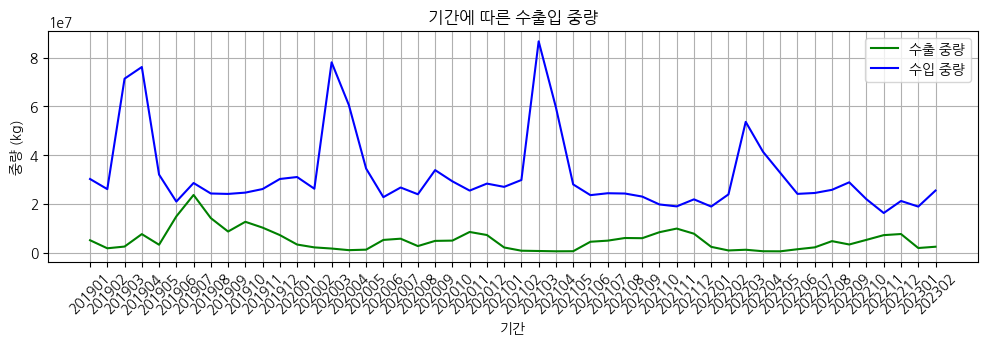

In [ ]:
plt.figure(figsize=(12, 3))
sns.lineplot(x='YearMonth', y='price(원/kg)', data=monthly_train_df, label='국내', color='green')
plt.title('기간에 따른 국내 단가')
plt.xlabel('기간')
plt.ylabel('금액 (원/kg)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 3))
sns.lineplot(x='YearMonth', y='수출 금액', data=monthly_data, label='수출', color='red')
sns.lineplot(x='YearMonth', y='수입 금액', data=monthly_data, label='수입', color='blue')
plt.title('기간에 따른 수출입 금액')
plt.xlabel('기간')
plt.ylabel('금액')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 3))
sns.lineplot(x='YearMonth', y='수출 중량', data=monthly_data, label='수출 중량', color='red')
sns.lineplot(x='YearMonth', y='수입 중량', data=monthly_data, label='수입 중량', color='blue')
plt.title('기간에 따른 수출입 중량')
plt.xlabel('기간')
plt.ylabel('중량 (kg)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
international_trade['품목명'].unique()

array(['토마토(신선한 것이나 냉장한 것으로 한정한다)', '양파', '쪽파', '꽃양배추와 브로콜리(broccoli)',
       '방울다다기 양배추', '양배추', '결구(結球) 상추',
       '위트루프 치커리(Witloof chicory)[시코리엄 인티부스 변종 포리오섬(Cichorium intybus var. foliosum)]',
       '당근', '오이류(신선한 것이나 냉장한 것으로 한정한다)',
       '콩[비그나(Vigna)속ㆍ파세러스(Phaseolus)속)]', '대추야자', '무화과', '파인애플',
       '망고(mango)', '망고스틴(mangosteen)', '오렌지', '감귤',
       '그레이프프루트(grapefruit)와 포멜로(pomelo)',
       '레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]', '수박',
       '포포(papaw)[파파야(papaya)]', '사과', '배', '자두',
       '완두[피섬 새티범(Pisum sativum)]', '구아바(guava)', '살구',
       '신 체리[프루너스 체라서스(Prunus cerasus)]', '복숭아[넥터린(nectarine)을 포함한다]',
       '순무', '방울토마토', '샬롯(shallot)', '참외'], dtype=object)

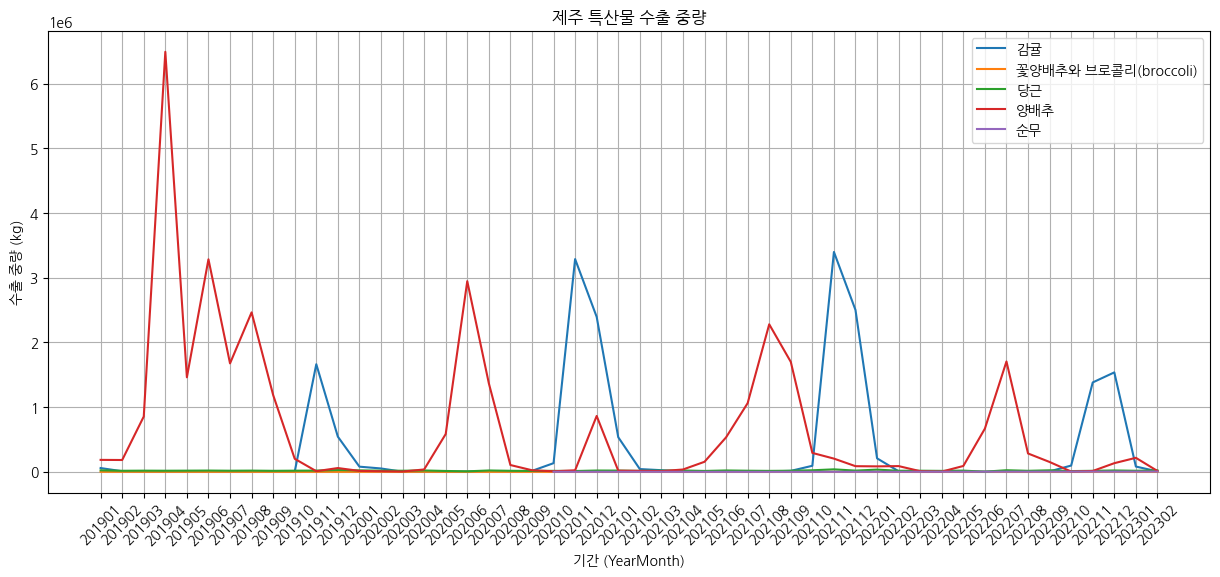

In [ ]:
items = ['감귤', '꽃양배추와 브로콜리(broccoli)', '당근', '양배추', '순무']

plt.figure(figsize=(15, 6))
for item in items:
    item_data = international_trade_no_datetime[international_trade_no_datetime['품목명'] == item]
    monthly_item_data = item_data.groupby('YearMonth').sum().reset_index()
    monthly_item_data['YearMonth'] = monthly_item_data['YearMonth'].astype(str)
    sns.lineplot(x='YearMonth', y='수출 중량', data=monthly_item_data, label=item)
plt.title('제주 특산물 수출 중량')
plt.xlabel('기간 (YearMonth)')
plt.ylabel('수출 중량 (kg)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

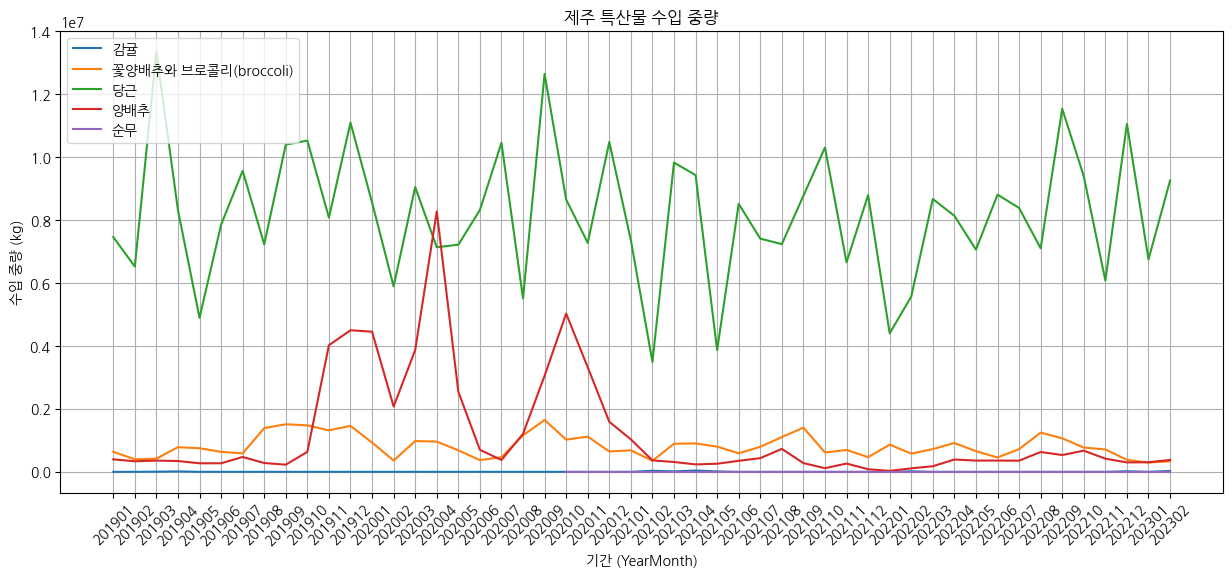

In [ ]:
items = ['감귤', '꽃양배추와 브로콜리(broccoli)', '당근', '양배추', '순무']

plt.figure(figsize=(15, 6))
for item in items:
    item_data = international_trade_no_datetime[international_trade_no_datetime['품목명'] == item]
    monthly_item_data = item_data.groupby('YearMonth').sum().reset_index()
    monthly_item_data['YearMonth'] = monthly_item_data['YearMonth'].astype(str)
    sns.lineplot(x='YearMonth', y='수입 중량', data=monthly_item_data, label=item)
plt.title('제주 특산물 수입 중량')
plt.xlabel('기간 (YearMonth)')
plt.ylabel('수입 중량 (kg)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
train_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
       'price(원/kg)', 'year', 'month', 'day'],
      dtype='object')

In [ ]:
test_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'year', 'month',
       'day'],
      dtype='object')

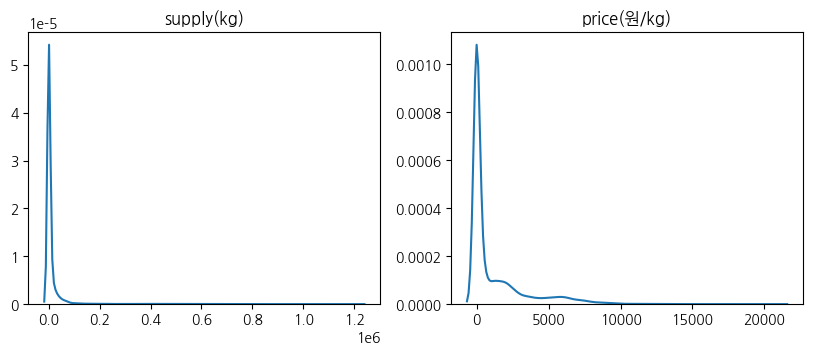

In [ ]:
col = ['supply(kg)', 'price(원/kg)']

plt.figure(figsize=(10, 8))

for i in range(len(col)):
    plt.subplot(2, 2, i+1, )
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.title(col[i])
    sns.kdeplot(train_df[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

In [ ]:
train_df["year"] = train_df["timestamp"].map(lambda x :x.year)
train_df["month"] = train_df["timestamp"].map(lambda x :x.month)
train_df["day"] = train_df["timestamp"].map(lambda x :x.day)
train_df["weekday"] = train_df["timestamp"].dt.weekday

test_df["year"] = test_df["timestamp"].map(lambda x :x.year)
test_df["month"] = test_df["timestamp"].map(lambda x: x.month)
test_df["day"] = test_df["timestamp"].map(lambda x: x.day)
test_df["weekday"] = test_df["timestamp"].dt.weekday

<Axes: xlabel='month', ylabel='supply(kg)'>

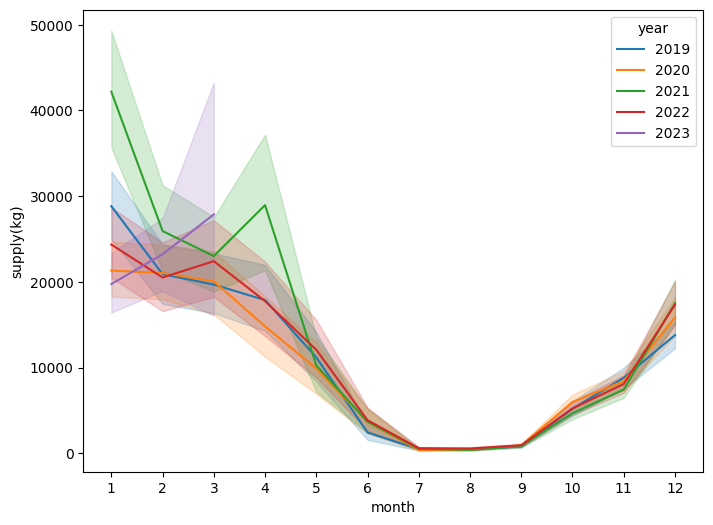

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=train_df, x='month', y = 'supply(kg)', hue='year')

<Axes: xlabel='month', ylabel='price(원/kg)'>

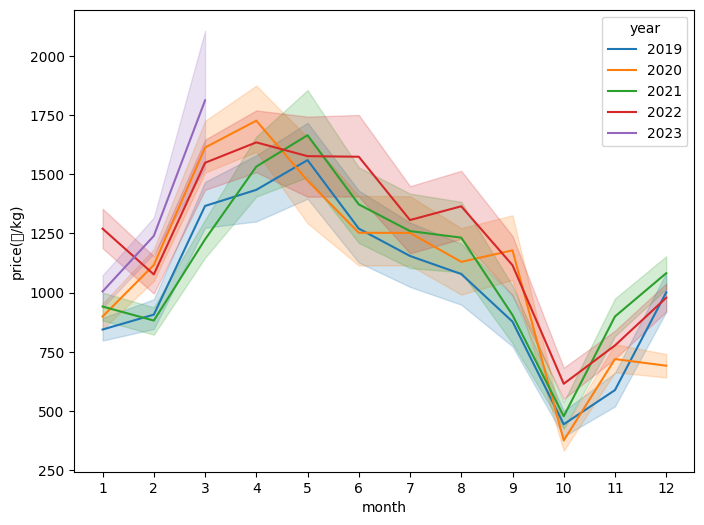

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=train_df, x='month', y = 'price(원/kg)', hue='year')

In [ ]:
train_df['item'].value_counts()

item
TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: count, dtype: int64

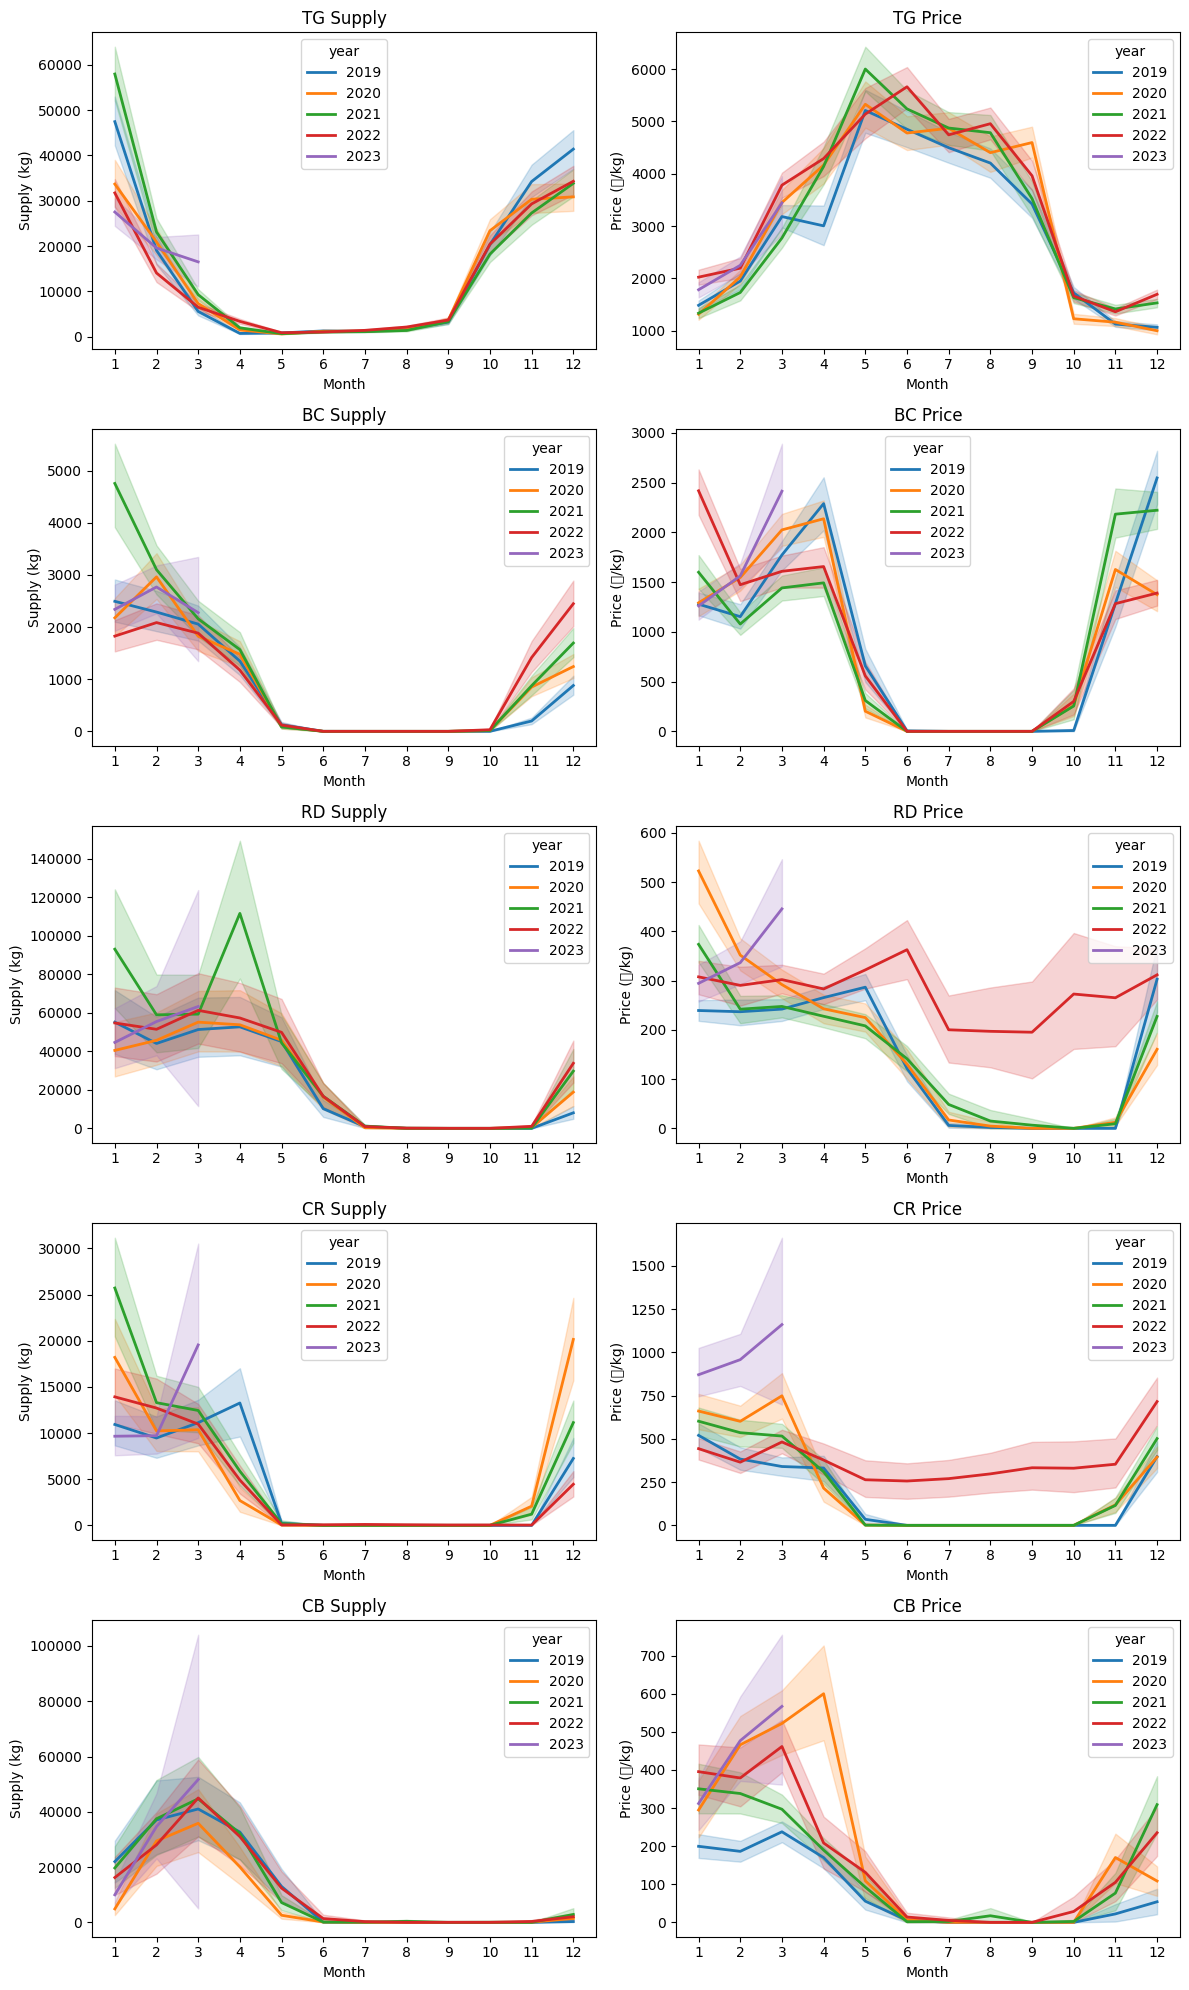

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 20))  # Adjusted figure size for 5x2 grid

item = ['TG', 'BC', 'RD', 'CR', 'CB']
num_items = len(item)

for idx, i in enumerate(item, 1):
    # First plot: Supply
    plt.subplot(num_items, 2, 2 * idx - 1)

    new_train = train_df[train_df['item']==i]
    sns.lineplot(data=new_train, x='month', y='supply(kg)', hue='year', linewidth=2)

    plt.title(f'{i} Supply')
    plt.xlabel('Month')
    plt.ylabel('Supply (kg)')

    # Second plot: Price
    plt.subplot(num_items, 2, 2 * idx)

    sns.lineplot(data=new_train, x='month', y='price(원/kg)', hue='year', linewidth=2)

    plt.title(f'{i} Price')
    plt.xlabel('Month')
    plt.ylabel('Price (원/kg)')

plt.tight_layout()
plt.show()


## Data Pre-Processing

In [ ]:
# #시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
# train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
# train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
# train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

# test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
# test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
# test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [ ]:
# #학습에 사용하지 않을 변수들을 제거합니다
# train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
# train_y = train_df['price(원/kg)']

# test_x = test_df.drop(columns=['ID', 'timestamp'])

In [ ]:
# #질적 변수들을 수치화합니다
# qual_col = ['item', 'corporation', 'location']

# for i in qual_col:
#     le = LabelEncoder()
#     train_x[i]=le.fit_transform(train_x[i])
#     test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage

# print('Done.')

Done.


In [ ]:
# 원핫인코딩
new_train = pd.get_dummies(train_df, columns = ['item', 'corporation', 'location'])
new_test = pd.get_dummies(test_df, columns = ['item', 'corporation', 'location'])

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = new_train.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = new_train['price(원/kg)']

test_x = new_test.drop(columns=['ID', 'timestamp'])

### RandomForest

In [ ]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

RandomForestRegressor()

In [ ]:
preds = model.predict(test_x)
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,3705.43
1,TG_A_J_20230305,0.00
2,TG_A_J_20230306,3559.51
3,TG_A_J_20230307,3350.75
4,TG_A_J_20230308,3293.84
...,...,...
1087,RD_F_J_20230327,489.46
1088,RD_F_J_20230328,496.65
1089,RD_F_J_20230329,464.37
1090,RD_F_J_20230330,437.83


In [ ]:
submission.to_csv('./randomforest_submission.csv', index=False)

### Catboost

In [ ]:
!pip install catboost

In [ ]:
cat_features = ['item', 'corporation', 'location', 'year', 'month', 'day']

In [ ]:
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp'])

In [ ]:
from catboost import CatBoostRegressor, Pool

train_pool = Pool(data=train_x, label=train_y)

cat_model = CatBoostRegressor(random_state=42, iterations=5000, verbose=0)
cat_model.fit(train_pool, verbose=100)

Learning rate set to 0.021095
0:	learn: 2001.5576042	total: 35.8ms	remaining: 2m 58s
100:	learn: 1118.2484876	total: 1.83s	remaining: 1m 28s
200:	learn: 1039.2831247	total: 4.56s	remaining: 1m 48s
300:	learn: 1006.7146910	total: 6.11s	remaining: 1m 35s
400:	learn: 985.1108976	total: 7.61s	remaining: 1m 27s
500:	learn: 970.9370861	total: 8.99s	remaining: 1m 20s
600:	learn: 960.4536246	total: 10.3s	remaining: 1m 15s
700:	learn: 951.5634871	total: 11.6s	remaining: 1m 11s
800:	learn: 943.3373285	total: 12.9s	remaining: 1m 7s
900:	learn: 936.0765260	total: 13.5s	remaining: 1m 1s
1000:	learn: 929.8778223	total: 14.2s	remaining: 56.8s
1100:	learn: 923.9830721	total: 15s	remaining: 53.3s
1200:	learn: 918.6670640	total: 16.4s	remaining: 52s
1300:	learn: 913.7314482	total: 17.9s	remaining: 50.9s
1400:	learn: 909.4346567	total: 19.4s	remaining: 49.8s
1500:	learn: 905.2386171	total: 20.9s	remaining: 48.6s
1600:	learn: 901.2067665	total: 21.7s	remaining: 46.1s
1700:	learn: 897.5213595	total: 22.4s	

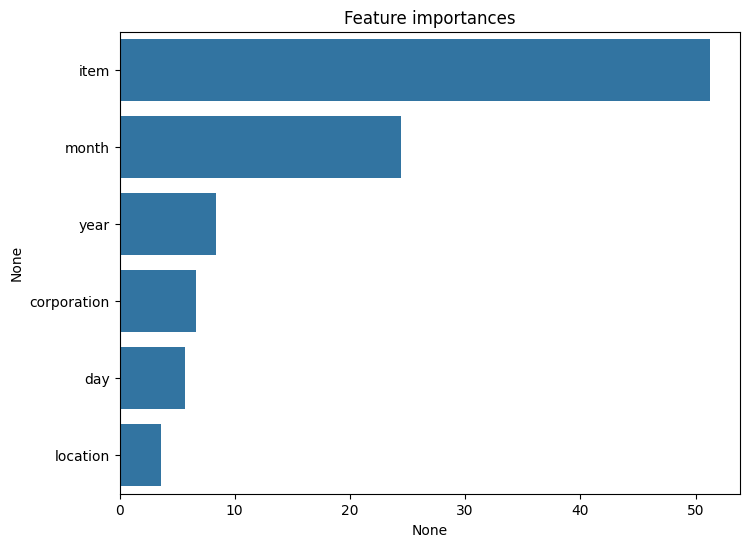

In [ ]:
cat_importances_values = cat_model.feature_importances_
cat_importances = pd.Series(cat_importances_values, index=train_x.columns)
cat_top20 = cat_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances')
sns.barplot(x=cat_top20, y=cat_top20.index)
plt.show()

In [ ]:
pred = cat_model.predict(test_x)
pred = [0 if i < 0 else i for i in pred]
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = pred
submission.to_csv('./catboost_submission.csv', index=False)

In [ ]:
pred = cat_model.predict(test_x)
pred = [0 if i < 0 else i for i in pred]
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = pred
submission.to_csv('./catboost1_submission.csv', index=False)

In [ ]:
test_df['item'].unique()

array(['TG', 'CR', 'CB', 'RD', 'BC'], dtype=object)

### item

In [ ]:
train_TG = train_df[train_df['item'] == 'TG']
train_CR = train_df[train_df['item'] == 'CR']
train_CB = train_df[train_df['item'] == 'CB']
train_RD = train_df[train_df['item'] == 'RD']
train_BC = train_df[train_df['item'] == 'BC']


test_TG = test_df[test_df['item'] == 'TG']
test_CR = test_df[test_df['item'] == 'CR']
test_CB = test_df[test_df['item'] == 'CB']
test_RD = test_df[test_df['item'] == 'RD']
test_BC = test_df[test_df['item'] == 'BC']

In [ ]:
import pandas as pd
from catboost import CatBoostRegressor, Pool

final = pd.DataFrame()

for i in ['TG', 'CR', 'CB', 'BC', 'RD']:
    new_train = train_df[train_df['item'] == i]
    new_test = test_df[test_df['item'] == i]

    train_x = new_train.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)', 'item'])
    train_y = new_train['price(원/kg)']
    test_x = new_test.drop(columns=['ID', 'timestamp', 'item'])
    # train_x = pd.get_dummies(train_x, columns=['corporation', 'location'], drop_first=True)
    # test_x = pd.get_dummies(test_x, columns=['corporation', 'location'], drop_first=True)

    train_pool = Pool(data=train_x, label=train_y, cat_features=['corporation', 'location'])

    cat_model = CatBoostRegressor(random_state=42, iterations=5000, verbose=0)
    cat_model.fit(train_pool, verbose=100)

    pred = cat_model.predict(test_x)
    pred = [0 if i < 0 else i for i in pred]

    item_pred_df = pd.DataFrame({'ID': new_test['ID'], 'prediction': pred})

    final = pd.concat([final, item_pred_df], ignore_index=True)


In [ ]:
pd.read_csv('./sample_submission.csv')

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [ ]:
final.sort_index(inplace=True)
final

,ID,prediction
0,TG_A_J_20230304,3155.460154
1,TG_A_J_20230305,179.118806
2,TG_A_J_20230306,3086.277634
3,TG_A_J_20230307,3233.792179
4,TG_A_J_20230308,3402.611043
...,...,...
1087,RD_F_J_20230327,462.875744
1088,RD_F_J_20230328,414.619613
1089,RD_F_J_20230329,432.214479
1090,RD_F_J_20230330,592.239245


In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission = submission.merge(final, on='ID', how='left')
submission['answer'] = submission['prediction']
submission.drop(columns=['prediction'], inplace=True)
submission.to_csv('./catboost2_submission.csv', index=False)

### XGB

In [ ]:
for i in cat_features:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i])

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1343899.1728494866


In [ ]:
pred = model.predict(test_x)
pred = [0 if i < 0 else i for i in pred]

submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = pred
submission.to_csv('./xgb_submission.csv', index=False)

### LGBM

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, num_boost_round=100)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 47517, number of used features: 6
[LightGBM] [Info] Start training from score 1129.750910
Mean Squared Error: 1539914.2005833252


In [ ]:
pred = model.predict(test_x)
pred = [0 if i < 0 else i for i in pred]

submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = pred
submission.to_csv('./lgbm_submission.csv', index=False)